# Libraries

In [89]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, average_precision_score


# Load Images

In [2]:
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))
        if img is not None:
            images.append(img)
    return images



# Load Training Images 

In [3]:
Training_label_folder_dict = {
    "glioma": "PreProcesed_images/Trainning/glioma",
    "meningioma": "PreProcesed_images/Trainning/meningioma",
    "notumor": "PreProcesed_images/Trainning/notumor",
    "pituitary": "PreProcesed_images/Trainning/pituitary",
}
Training_label_images_dict = {}
for label, folder_path in Training_label_folder_dict.items():
    if os.path.isdir(folder_path):
        images = load_images_from_folder(folder_path)
        Training_label_images_dict[label] = images
    else:
        print(f"Folder path '{folder_path}' for label '{label}' does not exist.")
for label, images in Training_label_images_dict.items():
    print(f"Label: {label}, Number of images: {len(images)}")

Label: glioma, Number of images: 1321
Label: meningioma, Number of images: 1339
Label: notumor, Number of images: 1595
Label: pituitary, Number of images: 1457


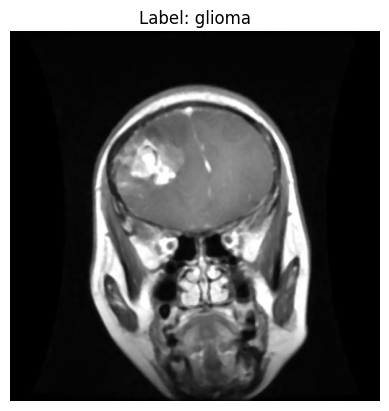

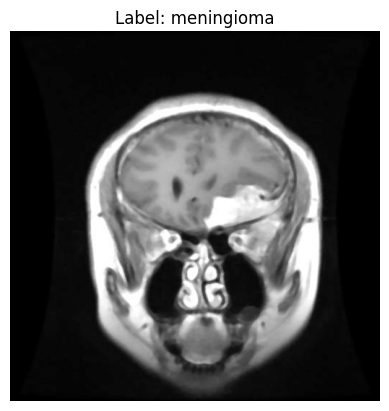

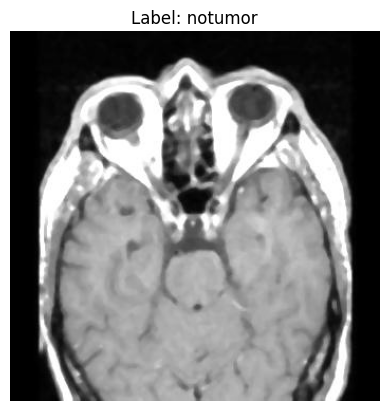

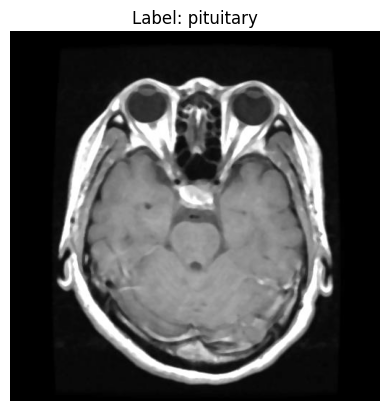

In [4]:
for label, images in Training_label_images_dict.items():
    if images:
        plt.figure()
        plt.imshow(images[0])  
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No images found for label: {label}")

# Load Testing Data 

In [5]:
Testing_label_folder_dict = {
    "glioma": "Testing/glioma",
    "meningioma": "Testing/meningioma",
    "notumor": "Testing/notumor",
    "pituitary": "Testing/pituitary",
}
Testing_label_images_dict = {}
for label, folder_path in Testing_label_folder_dict.items():
    if os.path.isdir(folder_path):
        images = load_images_from_folder(folder_path)
        Testing_label_images_dict[label] = images
    else:
        print(f"Folder path '{folder_path}' for label '{label}' does not exist.")
for label, images in Testing_label_images_dict.items():
    print(f"Label: {label}, Number of images: {len(images)}")


Label: glioma, Number of images: 300
Label: meningioma, Number of images: 306
Label: notumor, Number of images: 405
Label: pituitary, Number of images: 300


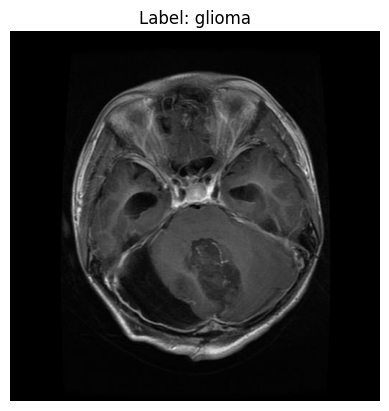

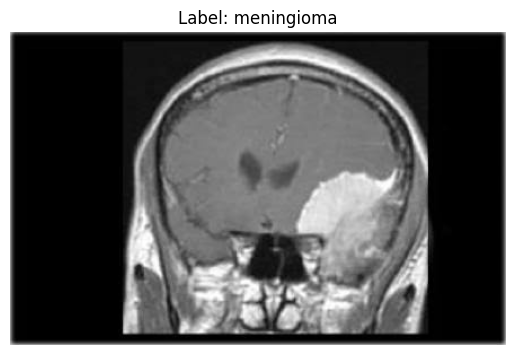

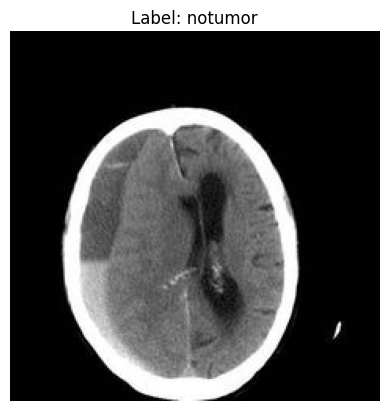

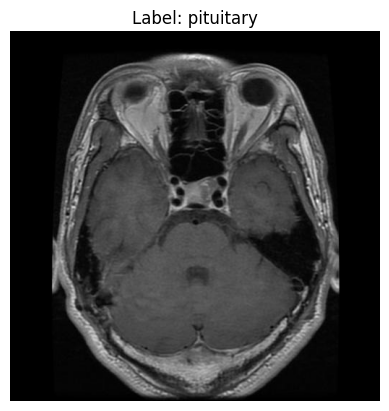

In [6]:
for label, images in Testing_label_images_dict.items():
    if images:
        plt.figure()
        plt.imshow(images[0])  
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No images found for label: {label}")

# Reshape the images 

In [7]:
def preprocess_images_vgg(images):
    processed_images = []
    for img in images:
        # Resize the image to (32, 32)
        img = img.resize((32, 32))                    # Convert image to numpy array
        img_array = np.array(img)                              
        processed_images.append(img_array)
    return np.array(processed_images)

# Load The VGG-19 

In [8]:
INPUT_SHAPE = (32, 32, 3)

# Get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False,input_shape=INPUT_SHAPE)

                                # We are adding our own layer
vgg_layers.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

# Fine tuning
our data set is larger so we fine tune all the layers

In [9]:

for layer in vgg_layers.layers:
    layer.trainable = True    # True means we train thata layer
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Conv2D name=block1_conv1, built=True> True
<Conv2D name=block1_conv2, built=True> True
<MaxPooling2D name=block1_pool, built=True> True
<Conv2D name=block2_conv1, built=True> True
<Conv2D name=block2_conv2, built=True> True
<MaxPooling2D name=block2_pool, built=True> True
<Conv2D name=block3_conv1, built=True> True
<Conv2D name=block3_conv2, built=True> True
<Conv2D name=block3_conv3, built=True> True
<Conv2D name=block3_conv4, built=True> True
<MaxPooling2D name=block3_pool, built=True> True
<Conv2D name=block4_conv1, built=True> True
<Conv2D name=block4_conv2, built=True> True
<Conv2D name=block4_conv3, built=True> True
<Conv2D name=block4_conv4, built=True> True
<MaxPooling2D name=block4_pool, built=True> True
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<Conv2D name=block5_conv4, built=True> True
<MaxPooling2D name=block5_pool, built=True> True


# Separate images and Labels

In [28]:
train_images = []
train_labels = []
for label, images in Training_label_images_dict.items():
    train_images.extend(images)
    train_labels.extend([label] * len(images))
test_images = []
test_labels = []
for label, images in Testing_label_images_dict.items():
    test_images.extend(images)
    test_labels.extend([label] * len(images))



# Check the shape and convert to numpy

In [11]:

image_width = 32
image_height = 32

# Convert JpegImageFile objects to NumPy arrays and resize images to a fixed size
resized_images = [np.array(img.resize((image_width, image_height))) for img in train_images]
# Convert the resized images and labels into NumPy arrays
train_images_array = np.array(resized_images)
train_labels_array = np.array(train_labels)

                                    # Check the shapes of the arrays
print(train_images_array.shape)
print(train_labels_array.shape)

(5712, 32, 32, 3)
(5712,)


In [49]:
from PIL import Image
import numpy as np

image_width = 32
image_height = 32

test_images_array = np.array([np.array(img.convert('L').resize((image_width, image_height))) for img in test_images])
test_labels_array = np.array(train_labels)

# Check the shapes of the arrays
print(test_images_array.shape)

(1311, 32, 32)


# Encode the lables 

In [43]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.fit_transform(test_labels)
print(train_labels_encoded.dtype)
print(train_images_array.dtype)



int64
uint8


# Build cnn on top vgg-19

In [23]:
input_shape = (32, 32, 3)

input_layer = Input(shape=input_shape)

# VGG layers
x = vgg_layers(input_layer)
x = Flatten()(x)
# Dense layers
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(4, activation='softmax')(x)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,459,780 (78.05 MB)

 Trainable params: 20,459,780 (78.05 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the model 

In [24]:

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)
# Define number of epochs
EPOCHS = 10
# Train the model
history = model.fit(
    train_images_array, train_labels_encoded,
    batch_size=32,
    validation_split=0.1,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.5972 - loss: 0.8765 - val_accuracy: 0.7605 - val_loss: 0.9579
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.6836 - loss: 0.6729 - val_accuracy: 0.3287 - val_loss: 3.5066
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.6125 - loss: 0.8566 - val_accuracy: 0.8147 - val_loss: 0.7827
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.6941 - loss: 0.6516 - val_accuracy: 0.7937 - val_loss: 0.7708
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6956 - loss: 0.6559 - val_accuracy: 0.8846 - val_loss: 0.6077
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.7003 - loss: 0.5900 - val_accuracy: 0.7325 - val_loss: 0.9502
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.7064 - loss: 0.6082 - val_accuracy: 0.8357 - val_loss: 0.6840
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.7028 - loss: 0.6158 - val_accu

# Prediction

In [ ]:
predictions = model.predict(train_images_array)
predicted_labels = np.argmax(predictions, axis=1)

# Clasification Report

In [61]:
print("Classification Report:")
print(classification_report(train_labels_encoded, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.99      0.69      1321
           1       0.50      0.01      0.02      1339
           2       0.91      0.99      0.95      1595
           3       0.94      0.94      0.94      1457

    accuracy                           0.75      5712
   macro avg       0.72      0.73      0.65      5712
weighted avg       0.73      0.75      0.67      5712



# Confusion Report

Confusion Matrix:


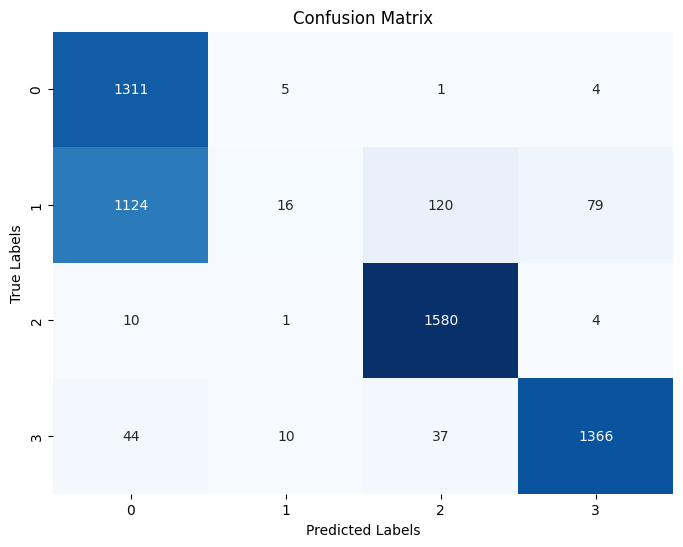

In [66]:
conf_matrix = confusion_matrix(train_labels_encoded, predicted_labels)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve

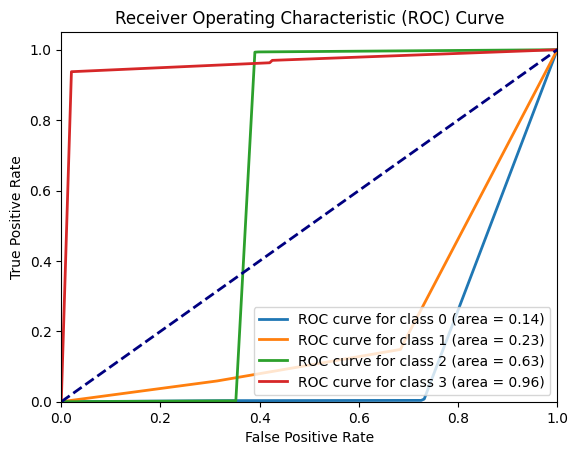

In [79]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(train_labels_encoded, predicted_labels, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {} (area = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Precision-Recall curve

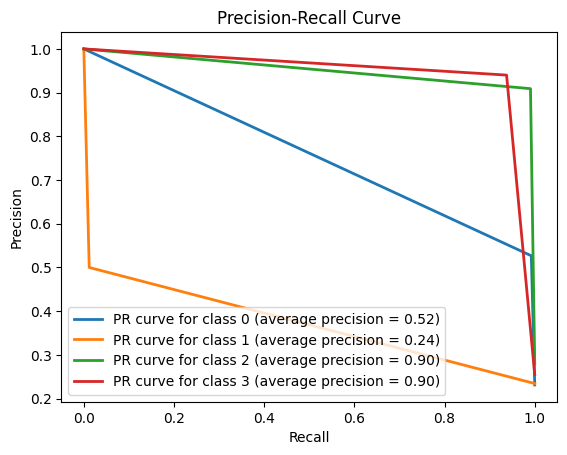

In [78]:
precision = {}
recall = {}
average_precision = {}
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(train_labels_encoded == i, predicted_labels == i)
    average_precision[i] = average_precision_score(train_labels_encoded == i, predicted_labels == i)

# Plot Precision-Recall curve for each class
plt.figure()
for i in range(4):
    plt.plot(recall[i], precision[i], lw=2, label='PR curve for class {} (average precision = {:.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()